# Model for aimpoint drift (aka ACA alignment drift) 2025-03

This notebook documents and computes fit coefficients for a simple model that
gives the relative ACA alignment as a linear function of the ACA CCD temperature.
It also includes validation of the implementation of the new model in the
`chandra_aca.drift` package.

## Summary

This is based on the `fit_aimpoint_drift-2022-11` notebook but updated through
2025:060 to include data after the 2023:046 Safe Mode normal sun dwell. Two jumps were
added:
- 2023:046 Safe Mode (approx 4 arcsec)
- 2024:001 Correct for apparent slow recovery from 2023:046 jump (approx 0.8 arcsec)

### Details

The ACA alignment is measured accurately for each science observation via the apparent
positions of the fid lights.  These are referred to by their CXC aspect solution
designation as the SIM DY and DZ offsets.  This is actually a misnomer based on
the pre-launch understanding of what physical mechanism would generate such offsets.
We now know via HRMA optical axis measurements that a temperature-dependent change 
in the ACA boresight alignment is responsible.  The HRMA to SIM alignment is quite
stable.

The ACA alignment relates directly to the X-ray detector aimpoint that is used in
observation planning and analysis.  With this model it will be possible to improve
the aimpoint accuracy by introducing a dynamic pointing offset based on the
predicted ACA CCD temperature for each observation.

The model is
```
DY/Z = (t_ccd - offset) * scale + (year - 2016.0) * trend + JUMPS
```
where
```
  t_ccd : ACA CCD temperature (degF)
  scale : scaling in arcsec / degF
  offset : ACA CCD temperature corresponding to DY/Z = 0.0 arcsec
  trend : Trend in DY/Z (arcsec / year)
  year : decimal year
  jumpYYYYDDD : step function from 0.0 to jumpYYYYDDD (arcsec) for date > YYYY:DDD
```
The jumps are persistent step function changes in alignment that have been observed following
extended dwells at normal sun where the ACA gets substantially hotter than during
normal operations.  The exact mechanism is not understood, but could be due to
a non-linear stiction release of a stress point that impacts alignment.

Note that the ACA alignment has a direct linear correlation to the ACA housing temperature (AACH1T).
However, in this model we use the ACA CCD temperature as the model dependent variable because it
is linearly related to housing temperature (AACCDPT = m * AACH1T + b) as long as the TEC is at
max drive current. Since there is already
an existing Xija model to predict ACA CCD temperature this reduces duplication.

The key fit results are:
```
DY
-----
scale = 2.1 arcsec / degF = 3.9 arcsec / degC
trend = -0.95 arcsec / year
new jump: 3.5 arcsec (2023:046)
new jump: -0.7 arcsec (2024:001) (recovery from 2023:046)

model error = +/- 2.1 arcsec (1st to 99th percentile range)

DZ
-----
scale = 1.0 arcsec / degF = 1.8 arcsec / degC
trend = -0.09 arcsec / year
new jump = 1.7 arcsec (2023:046)
new jump = -0.4 arcsec (2024:001) (recovery from 2023:046)

model error = +/- 2.8 arcsec (1st to 99th percentile range)

```

The model accuracy will be degraded somewhat when ACA CCD temperature
is taken from a predictive Xija model instead of from telemetry.

*This notebook lives in the **aimpoint_mon** project repository*

## Code

In [1]:
import os
import sys

# 2025-03 update relies on a dev version of chandra_aca.drift. Remove for next update.
sys.path.insert(0, os.path.join(os.environ["HOME"], "git", "chandra_aca"))
import json
import os
import sys
from pathlib import Path
from pprint import pprint
from typing import List, Optional

import astropy.table as tbl
import astropy.units as u
import cheta.fetch_eng as fetch
import matplotlib.pyplot as plt
import numpy as np
import tables
from astropy.table import Table
from chandra_aca import drift
from cheta import fetch_sci
from cxotime import CxoTime
from kadi import events
from sherpa import ui
from Ska.Numpy import interpolate
from ska_helpers import chandra_models
from ska_matplotlib import plot_cxctime
from tqdm import tqdm


failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


In [2]:
%matplotlib inline

In [3]:
SIM_MM_TO_ARCSEC = 20.493

In [4]:
# Discrete jumps after 2012:001 that are not already captured in the aimpoint drift
# model.  Note also older jumps at:
#   '2008:293',  # IU-reset
#   '2010:151',  # IU-reset
#   '2011:190',  # Safe mode
NEW_JUMP_DATES = [
    "2023:048",  # Safe Mode
    "2024:001",  # Ad hoc
]

In [5]:
ltt_bads = events.ltt_bads(pad=(0, 200000))
normal_suns = events.normal_suns(pad=(0, 100000))
safe_suns = events.safe_suns(pad=(0, 86400 * 7))

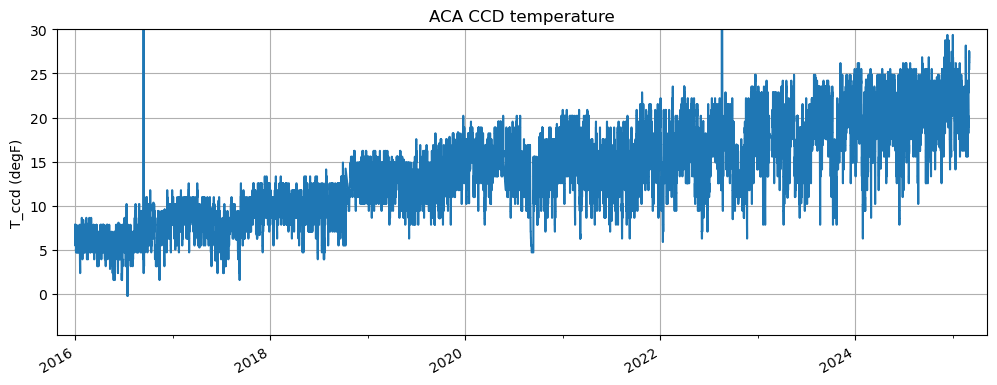

In [6]:
# Aspect camera CCD temperature trend in the last year
t_ccd = fetch.Msid("aacccdpt", start="2016:001", stat="5min")
t_ccd.remove_intervals(ltt_bads | normal_suns | safe_suns)
plt.figure(figsize=(12, 4.5))
t_ccd.plot()
plt.ylabel("T_ccd (degF)")
plt.title("ACA CCD temperature")
plt.ylim(None, 30)
plt.grid()

In [7]:
# Get aspect solution DY and DZ (apparent SIM offsets via fid light positions)
# which are sampled at 1 ksec intervals and updated daily.
if "adat" not in globals():
    with tables.open_file(
        f"{os.environ['SKA']}/data/aimpoint_mon3/aimpoint_asol_values.h5"
    ) as h5:
        adat = h5.root.data[:]

    adat.sort(order=["time"])

    # Filter bad data when asol DY and DZ are both exactly 0.0 (doesn't happen normally)
    bad = (adat["dy"] == 0.0) & (adat["dz"] == 0.0)
    adat = adat[~bad]

In [8]:
# Get the observed aimpoints trending data. This is maintained with a cron job on HEAD
# that uses DMCOORDS along with the event file DY_AVG and DZ_AVG values (referring to
# aspect solution DY, DZ) to compute the observed aimpoints CHIPX and CHIPY. The data is
# stored in the file observed_aimpoints.dat. Then the values `dx`, `dy`, `dr` are
# computed from the observed - planned CHIPX and CHIPY values.
aim_obs = Table.read(
    f"{os.environ['SKA']}/data/aimpoint_mon3/observed_aimpoints.dat",
    format="ascii.ecsv",
)

In [9]:
aim_obs[0]

aca_dec,aca_offset_y,aca_offset_z,aca_ra,aca_roll,chip_id,chipx,chipy,detector,dr,dx,dy,mean_date,mean_t_ccd,obs_chipx,obs_chipy,obsid,sim_z,sim_z_off,target_dec,target_offset_y,target_offset_z,target_ra,target_roll
float64,float64,float64,float64,float64,int64,float64,float64,str6,float64,float64,float64,str21,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64
86.237265,7.52,0.53,90.690629,67.667283,3,930.2,1009.6,ACIS-I,2.64,2.11,-1.58,2016:242:05:20:07.816,-13.84,621.03,707.94,18286,-233.587434461,0.00,86.239889,-150.0,150.0,89.7625,68.593411


In [10]:
def plot_observed_aimpoints(
    obs_aimpoints, lookback=365, axis="dx", ax=None, markersize=8, alpha=0.5
):
    """
    Make plot of data in the ``obs_aimpoints`` table.

    This is adapted from the same function in ``update_observed_aimpoints.py``.
    """

    dates = CxoTime(obs_aimpoints["mean_date"])
    years = dates.frac_year
    times = dates.secs
    ok = years > np.max(years) - float(lookback) / 365.25
    obs_aimpoints = obs_aimpoints[ok]
    times = times[ok]

    lolims = {}
    uplims = {}

    lolims[axis] = obs_aimpoints[axis] > 15
    uplims[axis] = obs_aimpoints[axis] < -15
    obs_aimpoints[axis] = obs_aimpoints[axis].clip(-15, 15)

    if ax is None:
        _, ax = plt.subplots(figsize=(8, 4))

    label = "CHIPX" if axis == "dx" else "CHIPY"

    for det, c in zip(
        ["HRC-I", "HRC-S", "ACIS-S", "ACIS-I"], ["cyan", "magenta", "blue", "red"]
    ):
        offset_ok = (np.abs(obs_aimpoints["target_offset_y"]) < 100) & (
            np.abs(obs_aimpoints["target_offset_z"]) < 100
        )
        det_ok = obs_aimpoints["detector"] == det
        ok = offset_ok & det_ok
        nok = ~offset_ok & det_ok

        kwargs = {
            "markeredgecolor": "k",
            "markeredgewidth": 0.5,
            "linestyle": "",
            "markersize": markersize,
            "ax": ax,
            "markerfacecolor": c,
        }
        if np.count_nonzero(ok):
            plot_cxctime(
                times[ok],
                obs_aimpoints[axis][ok],
                marker=".",
                alpha=alpha,
                label=det,
                **kwargs,
            )
        if np.count_nonzero(nok):
            plot_cxctime(
                times[nok],
                obs_aimpoints[axis][nok],
                marker="*",
                **kwargs,
            )
        if np.any(lolims[axis]):
            plot_cxctime(
                times[lolims[axis]],
                obs_aimpoints[axis][lolims[axis]],
                marker=".",
                yerr=1.5,
                lolims=True,
                **kwargs,
            )
        if np.any(uplims[axis]):
            plot_cxctime(
                times[uplims[axis]],
                obs_aimpoints[axis][uplims[axis]],
                marker=".",
                yerr=1.5,
                uplims=True,
                **kwargs,
            )
    ax.grid(True)
    ax.set_ylim(-10, 10)
    ax.set_ylabel("Offset (arcsec)")
    ax.set_title("Observed aimpoint offsets {}".format(label))

    ax.legend(
        loc="upper left", fontsize="x-small", title="", framealpha=0.5, numpoints=1
    )


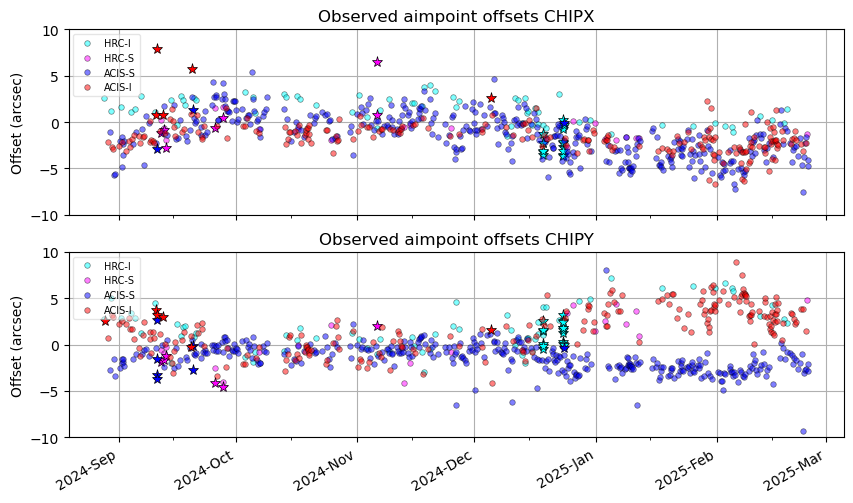

In [11]:
_, axes = plt.subplots(2, 1, figsize=(10, 6))
plot_observed_aimpoints(aim_obs, axis="dx", lookback=180, ax=axes[0])
plot_observed_aimpoints(aim_obs, axis="dy", lookback=180, ax=axes[1])

In [12]:
class AcaDriftModel(object):
    """
    Class to encapsulate necessary data and compute the model of ACA
    alignment drift.  The object created from this class is called
    by Sherpa as a function during fitting.  This gets directed to
    the __call__() method.
    """

    def __init__(self, adat, axis, pars, start="2012:001", stop=None):
        """
        adat is the raw data array containing aspect solution data
        sampled at 1 ksec intervals.
        """
        self.pars = pars
        self.axis = axis
        self.name = f"aca_drift_model_{axis}"

        # Get the ACA CCD temperature telemetry
        t_ccd = fetch.Msid("aacccdpt", stat="5min", start=start, stop=stop)

        # Slice the ASOL data corresponding to available ACA CCD temps
        i0, i1 = np.searchsorted(adat["time"], [t_ccd.times[0], t_ccd.times[-1]])
        self.asol = adat[i0:i1].copy()

        # Convert from mm to arcsec for convenience
        self.asol["dy"] *= SIM_MM_TO_ARCSEC
        self.asol["dz"] *= SIM_MM_TO_ARCSEC

        self.times = self.asol["time"]
        self.years = CxoTime(self.times, format="cxcsec").decimalyear

        # Resample CCD temp. data to the 1 ksec ASOL time stamps
        self.t_ccd = interpolate(
            t_ccd.vals, t_ccd.times, self.asol["time"], method="linear"
        )

        # Get indices corresponding to jump times for later model computation
        jump_dates = [jump[0] for jump in self.pars["jumps"]]
        self.jump_times = CxoTime(jump_dates).secs
        self.jump_idxs = np.searchsorted(self.times, self.jump_times)

    @property
    def model(self):
        return globals()[self.name]

    @property
    def parvals(self):
        return [par.val for par in self.model.pars]

    def __call__(self, pars, years=None, t_ccd=None):
        """
        Calculate model prediction for DY or DZ.  Params are:

          scale : scaling in arcsec / degF
          offset : ACA CCD temperature corresponding to DY/Z = 0.0 arcsec
          trend : Trend in DY/Z (arcsec / year)
          jumpYYYYDDD : discrete jump in arcsec at date YYYY:DDD
        """
        if years is None:
            years = self.years

        # Sherpa passes the parameters as a list
        year0, scale, offset, trend = pars[:4]
        jumps = pars[4:]

        # Allow for passing in a different value for ACA CCD temperature
        if t_ccd is None:
            t_ccd = self.t_ccd

        # Compute linear part of model
        out = (t_ccd - offset) * scale + (years - year0) * trend

        # Put in the step function jumps
        for jump_idx, jump in zip(self.jump_idxs, jumps):
            if jump_idx > 10 and jump_idx < len(out) - 10:
                out[jump_idx:] += jump

        return out

In [13]:
def convert_json_pars_to_sherpa_pars(json_pars):
    """
    Convert a JSON pars dict into a sherpa pars dict.
    """
    sherpa_pars = {}
    for name in ("year0", "scale", "offset", "trend"):
        sherpa_pars[name] = json_pars[name]
    for date, parval in json_pars["jumps"]:
        par = f"jump{date.replace(':', '')}"
        sherpa_pars[par] = parval

    return sherpa_pars

In [14]:
def get_aca_drift_model(
    pars_prev: dict,
    axis: str = "dy",
    start: str = "2012:180",
    stop: Optional[str] = None,
    new_jump_dates: Optional[List[str]] = None,
):
    """
    Create ACA drift model and sherpa model for ACA drift in ``axis``
    (dy or dz) using ``pars_prev`` as the starting point.  If ``new_jump_dates`` is
    defined then add new jump parameters for those dates.

    The ``prev_pars`` dict should look like::

        DRIFT_Y_PARS = dict(
            year0=2016.0,
            scale=2.1467,  # drift per degF (NOT degC as elsewhere in this module)
            offset=-6.012,
            trend=-1.108,
            jumps=[
                ("2015:006", -4.600),
                ("2015:265", -4.669),
                ("2016:064", -1.793),
                ("2017:066", -1.725),
                ("2018:285", -12.505),
            ],
        )
    """
    # Flatten dates to "jumpYYYYDDD" and ensure correct order since sherpa model
    # evaluation depends on the order of the parameters.
    pars_sherpa_prev = convert_json_pars_to_sherpa_pars(pars_prev)

    # Make a new pars version and add the new jump parameters
    pars = pars_prev.copy()
    for date in new_jump_dates:
        pars["jumps"].append((date, 0.0))

    pars_sherpa = convert_json_pars_to_sherpa_pars(pars)

    # Create the object used to define the Sherpa user model, then
    # load as a model and create parameters
    aca_drift = AcaDriftModel(adat, axis, pars, start=start, stop=stop)

    ui.load_user_model(aca_drift, aca_drift.name)
    parnames = list(pars_sherpa)
    ui.add_user_pars(aca_drift.name, parnames)

    # Set the initial model parameter values to the previous model values and freeze
    for name, val in pars_sherpa_prev.items():
        par = getattr(aca_drift.model, name)
        par.val = val
        par.freeze()

    return aca_drift

In [15]:
def fit_aimpoint_aca_temp(aca_drift):
    """
    Use Sherpa to fit the model parameters
    """
    # Get the DY or DZ values and load as Sherpa data
    dyz = aca_drift.asol[aca_drift.axis]
    ui.load_arrays(1, aca_drift.years, dyz)

    # Set the model and fit using Simplex (Nelder-Mead) minimization
    ui.set_model(1, aca_drift.model)
    ui.set_method("simplex")
    ui.fit(1)

    return ui.get_fit_results()

In [16]:
def plot_aimpoint_drift(axis, aca_drift, start="2010:001", stop=None, ax=None):
    """
    Plot our results
    """
    y_start = CxoTime(start).frac_year
    y_stop = CxoTime(stop).frac_year
    years = aca_drift.years
    ok = (years > y_start) & (years < y_stop)
    years = aca_drift.years[ok]
    times = aca_drift.times[ok]

    # Call model directly with best-fit parameters to get model values
    model = aca_drift.model
    pars = [par.val for par in model.pars]
    dyz_fit = aca_drift(pars)[ok]

    # DY or DZ values from aspect solution
    dyz = aca_drift.asol[axis][ok]
    dyz_resid = dyz - dyz_fit

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    plot_cxctime(times, dyz_resid, ",", color="C0", label="Residual", ax=ax)
    ax.set_title(
        "Fit aspect solution {} to scaled ACA CCD temperature".format(axis.upper())
    )
    ax.set_ylabel("{} (arcsec)".format(axis.upper()))
    ax.grid(True)

    std = dyz_resid.std()
    p1, p99 = np.percentile(dyz_resid, [1, 99])
    print("Fit residual stddev = {:.2f} arcsec".format(std))
    print("Fit residual 99th - 1st percentile = {:.2f}".format(p99 - p1))

## Get current flight drift parameters

Here we will freeze those previous parameters and only fit for the new one

In [17]:
def get_flight_drift_model():
    from ska_helpers import chandra_models

    txt, info = chandra_models.get_data("chandra_models/aca_drift/aca_drift_model.json")
    pars_flight = json.loads(txt)
    return pars_flight, info

## Fit model coefficients for DY and plot results

In [18]:
# Get the previous model parameters and flatten into the sherpa format
pars_flight, info = get_flight_drift_model()
print(info["version"])


3.63


In [19]:
pars_flight

{'dy': {'year0': 2016.0,
  'scale': 2.1467,
  'offset': -6.012,
  'trend': -1.108,
  'jumps': [['2015:006', -4.6],
   ['2015:265', -4.669],
   ['2016:064', -1.793],
   ['2017:066', -1.725],
   ['2018:285', -12.505],
   ['2022:294', -7.966]]},
 'dz': {'year0': 2016.0,
  'scale': 1.004,
  'offset': -15.963,
  'trend': -0.159,
  'jumps': [['2015:006', -2.109],
   ['2015:265', -0.368],
   ['2016:064', -0.902],
   ['2017:066', -0.856],
   ['2018:285', -6.056],
   ['2022:294', -1.5133]]}}

In [20]:
aca_drift_dy = get_aca_drift_model(
    axis="dy", pars_prev=pars_flight["dy"], new_jump_dates=NEW_JUMP_DATES
)

In [21]:
aca_drift_dy.model

<UserModel model instance 'usermodel.aca_drift_model_dy'>

In [22]:
fit_dy = fit_aimpoint_aca_temp(aca_drift_dy)

Dataset               = 1
Method                = neldermead
Statistic             = chi2gehrels
Initial fit statistic = 61046.5
Final fit statistic   = 14257.1 at function evaluation 223
Data points           = 300735
Degrees of freedom    = 300733
Probability [Q-value] = 1
Reduced statistic     = 0.0474079
Change in statistic   = 46789.4
   aca_drift_model_dy.jump2023048   -3.53795    
   aca_drift_model_dy.jump2024001   0.693547    


In [23]:
fit_dy.parnames

('aca_drift_model_dy.jump2023048', 'aca_drift_model_dy.jump2024001')

In [24]:
CxoTime(aca_drift_dy.times[-1]).date

'2025:055:10:21:55.115'

Fit residual stddev = 0.89 arcsec
Fit residual 99th - 1st percentile = 4.16


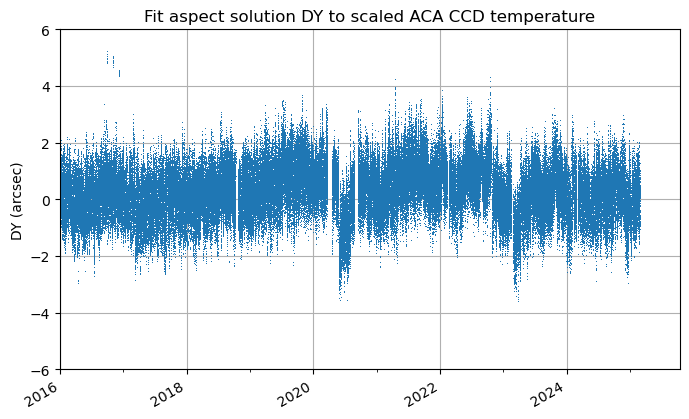

In [25]:
_, ax = plt.subplots(figsize=(8, 5))
plot_aimpoint_drift("dy", aca_drift_dy, ax=ax)
ax.set_ylim(-6, 6)
ax.set_xlim(CxoTime("2016:001").plot_date, None);

### Illustrate model behavior by assuming a constant ACA CCD temperature

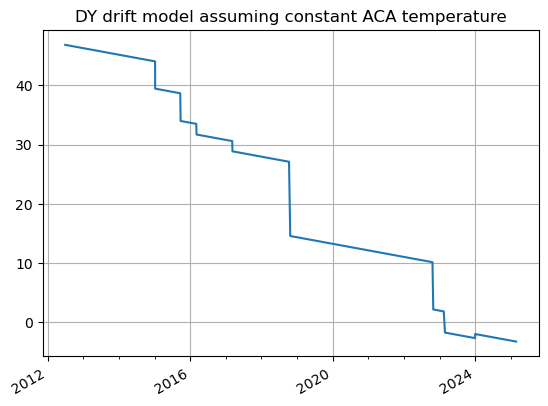

In [26]:
dyz_fit = aca_drift_dy(aca_drift_dy.parvals, t_ccd=14)  # degF = -10 C
plot_cxctime(aca_drift_dy.times, dyz_fit)
plt.title("DY drift model assuming constant ACA temperature")
plt.grid()

## Fit model coefficients for DZ and plot results

In [27]:
aca_drift_dz = get_aca_drift_model(
    axis="dz", pars_prev=pars_flight["dz"], new_jump_dates=NEW_JUMP_DATES
)

In [28]:
fit_dz = fit_aimpoint_aca_temp(aca_drift_dz)

Dataset               = 1
Method                = neldermead
Statistic             = chi2gehrels
Initial fit statistic = 21683.7
Final fit statistic   = 18074.4 at function evaluation 237
Data points           = 300735
Degrees of freedom    = 300733
Probability [Q-value] = 1
Reduced statistic     = 0.0601013
Change in statistic   = 3609.25
   aca_drift_model_dz.jump2023048   -1.73572    
   aca_drift_model_dz.jump2024001   0.396765    


Fit residual stddev = 1.32 arcsec
Fit residual 99th - 1st percentile = 5.77


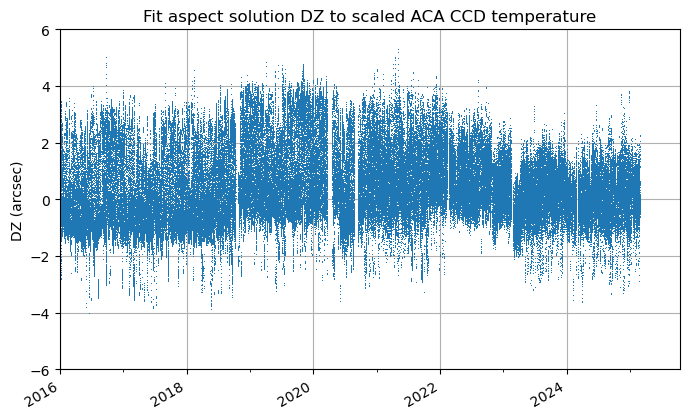

In [29]:
_, ax = plt.subplots(figsize=(8, 5))
plot_aimpoint_drift("dz", aca_drift_dz, ax=ax)
ax.set_ylim(-6, 6)
ax.set_xlim(CxoTime("2016:001").plot_date, None);

### Illustrate model behavior by assuming a constant ACA CCD temperature

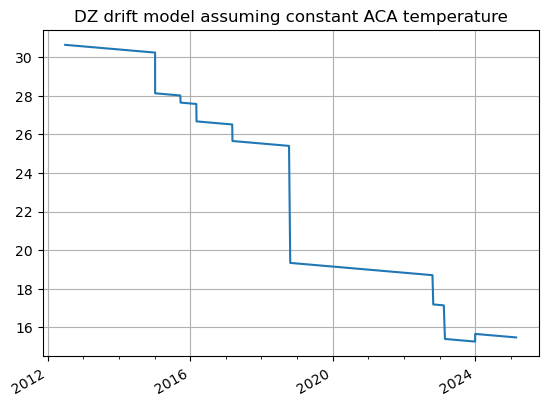

In [30]:
dyz_fit = aca_drift_dz(aca_drift_dz.parvals, t_ccd=14)  # degF = -10 C
plot_cxctime(aca_drift_dz.times, dyz_fit)
plt.title("DZ drift model assuming constant ACA temperature")
plt.grid()

In [31]:
def write_drift_pars(path, aca_drift_dy, aca_drift_dz):
    """
    Write out the fit results in a JSON file
    """
    pars = {}
    for axis, aca_drift in (("dy", aca_drift_dy), ("dz", aca_drift_dz)):
        pars[axis] = {}
        jumps = []
        for par in aca_drift.model.pars:
            parname = par.name
            parval = par.val
            parname = parname.replace(f"{aca_drift.name}.", "")
            if parname.startswith("jump"):
                parname = parname.replace("jump", "")
                date = parname[:4] + ":" + parname[4:]
                jumps.append([date, round(parval, 4)])
            else:
                pars[axis][parname] = round(parval, 4)
        pars[axis]["jumps"] = jumps

    with open(path, "w") as fh:
        json.dump(pars, fh, indent=4)

In [32]:
write_drift_pars("aca_drift_model.json", aca_drift_dy, aca_drift_dz)
aca_drift_pars = json.loads(Path("aca_drift_model.json").read_text())

In [33]:
aca_drift_pars

{'dy': {'year0': 2016.0,
  'scale': 2.1467,
  'offset': -6.012,
  'trend': -1.108,
  'jumps': [['2015:006', -4.6],
   ['2015:265', -4.669],
   ['2016:064', -1.793],
   ['2017:066', -1.725],
   ['2018:285', -12.505],
   ['2022:294', -7.966],
   ['2023:048', -3.5379],
   ['2024:001', 0.6935]]},
 'dz': {'year0': 2016.0,
  'scale': 1.004,
  'offset': -15.963,
  'trend': -0.159,
  'jumps': [['2015:006', -2.109],
   ['2015:265', -0.368],
   ['2016:064', -0.902],
   ['2017:066', -0.856],
   ['2018:285', -6.056],
   ['2022:294', -1.5133],
   ['2023:048', -1.7357],
   ['2024:001', 0.3968]]}}

## Predicted aimpoint offsets with if new model had been used

This uses the mean per-observation flight CCD temperatures, not predicted.

In [34]:
start = CxoTime("2022:001")
stop = CxoTime.now()
ok = (
    (aim_obs["mean_date"] > start.date)
    & (aim_obs["mean_date"] < stop.date)
    & np.isin(aim_obs["detector"], ["ACIS-I", "ACIS-S"])
    & (np.abs(aim_obs["target_offset_y"]) < 100)
    & (np.abs(aim_obs["target_offset_z"]) < 100)
)
obs_recents = aim_obs[ok]

In [35]:
len(obs_recents)

3719

In [36]:
# For initial testing, set USE_CHANDRA_MODELS to False.
# Once a good model is available, install it in a branch in chandra_models via:
#  cd ~/git/chandra_models
#  git switch master
#  git pull
#  git switch -c aimpoint-drift-update
#  cp ~/git/aimpoint_drift/aca_drift_model.json chandra_models/aca_drift/
#  git add chandra_models/aca_drift/aca_drift_model.json
#  git commit -m "Update aimpoint drift model 2025-03"
USE_CHANDRA_MODELS = True

if USE_CHANDRA_MODELS:
    os.environ["CHANDRA_MODELS_REPO_DIR"] = os.path.join(
        os.environ["HOME"], "git", "chandra_models"
    )
    os.environ["CHANDRA_MODELS_DEFAULT_VERSION"] = "aimpoint-drift-update"

    mdl, info = chandra_models.get_data("chandra_models/aca_drift/aca_drift_model.json")
    print(f"Using chandra_models version: {info['version']}")
    pprint(json.loads(mdl))
    get_aca_offsets_kwargs = {}
else:
    get_aca_offsets_kwargs = {"aca_drift_pars": aca_drift_pars}

Using chandra_models version: aimpoint-drift-update
{'dy': {'jumps': [['2015:006', -4.6],
                  ['2015:265', -4.669],
                  ['2016:064', -1.793],
                  ['2017:066', -1.725],
                  ['2018:285', -12.505],
                  ['2022:294', -7.966],
                  ['2023:048', -3.5379],
                  ['2024:001', 0.6935]],
        'offset': -6.012,
        'scale': 2.1467,
        'trend': -1.108,
        'year0': 2016.0},
 'dz': {'jumps': [['2015:006', -2.109],
                  ['2015:265', -0.368],
                  ['2016:064', -0.902],
                  ['2017:066', -0.856],
                  ['2018:285', -6.056],
                  ['2022:294', -1.5133],
                  ['2023:048', -1.7357],
                  ['2024:001', 0.3968]],
        'offset': -15.963,
        'scale': 1.004,
        'trend': -0.159,
        'year0': 2016.0}}


In [37]:
t_ccd = fetch_sci.Msid(
    "aacccdpt", start=start - 5 * u.day, stop=stop + 5 * u.day, stat="5min"
)

if "dx_corr" not in obs_recents.colnames:
    obs_recents["dx_corr"] = 0.0
    obs_recents["dy_corr"] = 0.0

for obs in tqdm(obs_recents):
    dwell = events.manvrs.filter(obsid=obs["obsid"])[0]
    dwell_tstart = CxoTime(dwell.kalman_start).secs
    dwell_tstop = CxoTime(dwell.next_manvr_start).secs
    i0, i1 = np.searchsorted(t_ccd.times, [dwell_tstart, dwell_tstop])
    mean_t_ccd = np.mean(t_ccd.vals[i0:i1])
    offsets = drift.get_aca_offsets(
        obs["detector"],
        chip_id=obs["chip_id"],
        chipx=obs["chipx"],
        chipy=obs["chipy"],
        time=obs["mean_date"],
        t_ccd=mean_t_ccd,
        **get_aca_offsets_kwargs,
    )
    ddy = obs["aca_offset_y"] - offsets[0]
    ddz = obs["aca_offset_z"] - offsets[1]

    if obs["detector"] == "ACIS-I":
        obs["dx_corr"] = obs["dx"] - ddz
        obs["dy_corr"] = obs["dy"] + ddy
    elif obs["detector"] == "ACIS-S":
        obs["dx_corr"] = obs["dx"] - ddy
        obs["dy_corr"] = obs["dy"] - ddz
    else:
        # Ignore HRC
        pass

100%|██████████| 3719/3719 [00:41<00:00, 89.52it/s]


In [38]:
obs_recents["mean_date", "detector", "dx_corr", "dy_corr"]

mean_date,detector,dx_corr,dy_corr
str21,str6,float64,float64
2022:001:00:16:58.816,ACIS-S,0.30553372184360966,0.18041786438463292
2022:001:21:30:42.816,ACIS-S,0.667134903812608,-0.10511486254860758
2022:002:05:39:58.816,ACIS-S,0.9117348380297348,-0.021579887091371708
2022:002:12:05:22.816,ACIS-S,0.590778121486486,-0.03629967233023479
2022:002:15:46:46.816,ACIS-S,-0.4285602007899224,-1.3492178681931222
2022:002:19:44:34.816,ACIS-S,0.06892035806639296,0.44027838428334787
2022:003:01:42:38.816,ACIS-S,0.2918403250533923,1.28651694950921
2022:003:07:40:42.816,ACIS-S,0.4464070013776418,0.6671819814861893
2022:003:13:55:10.816,ACIS-I,0.6850681549226932,0.5078817219909881


In [39]:
obs_recents_copy = obs_recents.copy()
obs_recents_copy["dx"] = -obs_recents_copy["dx_corr"]
obs_recents_copy["dy"] = -obs_recents_copy["dy_corr"]

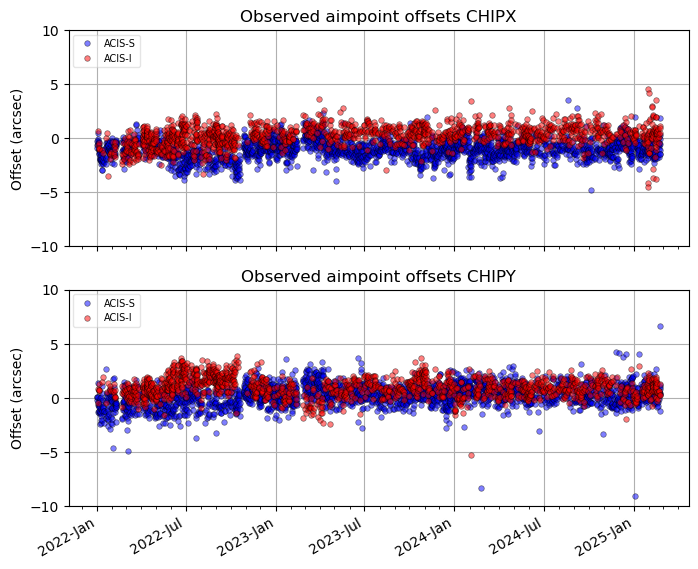

In [40]:
fig, axes = plt.subplots(2, 1, figsize=(8, 7))
for ax, axis in zip(axes, ["dx", "dy"]):
    plot_observed_aimpoints(obs_recents_copy, axis=axis, lookback=10000, ax=ax)
    ax.set_ylim(-10, 10)

In [41]:
def make_regression_data(aim_obs: tbl.Table) -> tbl.Table:
    """Make regression data using the planned aimpoint offsets from flight products.

    This pulls the first observation of the year for each detector.

    Of note is that prior to 2019 the aimpoint model was refit for all parameters so
    we do not expect an exact match. From 2018-11 forward we expect a match to within
    the reported precision (0.01 arcsec) for all historical data after 2018-11.
    """
    year_now = CxoTime.now().decimalyear.astype(int)
    rows = []
    for year in range(2019, year_now + 1):
        mean_dates_year = np.trunc(CxoTime(aim_obs["mean_date"]).decimalyear)
        for detector in ("ACIS-I", "ACIS-S", "HRC-I", "HRC-S"):
            ok = (mean_dates_year == year) & (aim_obs["detector"] == detector)
            idx = np.where(ok)[0][0]
            rows.append(aim_obs[idx])
    out = tbl.Table(rows=rows, names=aim_obs.colnames)
    for names in ("dx", "dy", "dr", "obs_chipx", "obs_chipy", "sim_z_off"):
        out[names] = np.round(out[names], 2)
    return out

In [42]:
regr_data = make_regression_data(aim_obs)

In [43]:
# Write out regression data. This can optionally be installed in
# chandra_aca/chandra_aca/tests/data/aimpoint_regression_data.csv
regr_data.write("aimpoint_regression_data.ecsv", format="ascii.ecsv", overwrite=True)

In [44]:
!cat aimpoint_regression_data.ecsv

# %ECSV 1.0
# ---
# datatype:
# - {name: aca_dec, datatype: float64}
# - {name: aca_offset_y, datatype: float64}
# - {name: aca_offset_z, datatype: float64}
# - {name: aca_ra, datatype: float64}
# - {name: aca_roll, datatype: float64}
# - {name: chip_id, datatype: int64}
# - {name: chipx, datatype: float64}
# - {name: chipy, datatype: float64}
# - {name: detector, datatype: string}
# - {name: dr, datatype: float64}
# - {name: dx, datatype: float64}
# - {name: dy, datatype: float64}
# - {name: mean_date, datatype: string}
# - {name: mean_t_ccd, datatype: float64}
# - {name: obs_chipx, datatype: float64}
# - {name: obs_chipy, datatype: float64}
# - {name: obsid, datatype: int64}
# - {name: sim_z, datatype: float64}
# - {name: sim_z_off, datatype: float64}
# - {name: target_dec, datatype: float64}
# - {name: target_offset_y, datatype: float64}
# - {name: target_offset_z, datatype: float64}
# - {name: target_ra, datatype: float64}
# - {name: target_roll, datatype: float64}
# schema: astrop